In [1]:
from eccodes import (
    codes_grib_new_from_file,
    codes_get_values,
    codes_set_values,
    codes_write
)
import cfgrib
import numpy as np
import pandas as pd
import xarray as xr
import psyplot.project as psy
from scipy.interpolate import griddata
import scipy.interpolate as interp

import matplotlib.pyplot as plt
import iconarray
import psyplot.project as psy

In [46]:
#####################################################
#
#        UTILITY FUNCTIONS
#
#####################################################

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def read_atab(file_data, file_data_mod):   
    with open(file_data) as f:
        for n, line in enumerate(f):
            if line.strip()[0:8] == 'Latitude':
                lat_stns = np.fromstring(line.strip()[10:], sep=' ')
            if line.strip()[0:9] == 'Longitude':
                lon_stns = np.fromstring(line.strip()[11:], sep=' ')
            if line.strip()[0:18] == 'Missing_value_code':
                missing_value = float(line.strip()[20:])
            if line.strip()[0:9] == 'Indicator':
                stn_indicators = np.array(line.strip()[11:].split('\t'))
            if n == 16:
                break
    with open(file_data_mod) as f:
        for n, line in enumerate(f):
            if line.strip()[0:9] == 'Indicator':
                stn_indicators_mod = np.array(line.strip()[29:].split('         '))
                break
    [_, is1, is2] = np.intersect1d(stn_indicators, stn_indicators_mod, assume_unique=True, return_indices=True)
    istation_mod = is2[np.argsort(is1)]
    data = pd.read_csv(file_data, \
                       header = 17, \
                       delim_whitespace=True,\
                      parse_dates = [[1,2,3,4,5]])

    data_mod = pd.read_csv(file_data_mod, \
                       header = 18, \
                       delim_whitespace=True,\
                      parse_dates = [[3,4,5,6,7]])
    return data, data_mod, lat_stns, lon_stns, missing_value, istation_mod

def treat_missing(array, missing_value = -9999.0, tune_pol_default = 1., verbose = False):
    array_missing = array == missing_value
    skip_missing = np.count_nonzero(array_missing)
    Nstations = array.shape[1]
    if skip_missing > 0:
        for istation in range(Nstations):
            if np.count_nonzero(np.abs(array[:,istation] - missing_value) < 0.01)/len(array[:,istation]) < 0.1:
                idx1 = np.where(np.abs(array[:,istation] - missing_value) > 0.01)
                idx2 = np.where(np.abs(array[:,istation] - missing_value) < 0.01)
                if verbose:
                    print(f'Less than 10% of the data is missing, \
                    mean of the rest is: {np.mean(array[idx1, istation])}')
                array[idx2, istation] = np.mean(array[idx1, istation])
            else:
                if verbose:
                    print('More than 10% of the data is missing')
                array[:,istation] = tune_pol_default
    return array

def update_strength_realtime(array, array_mod, istation_mod, ds, tune_pol_default = 1., eps = 1e-2, verbose = False):
    Nstations = array.shape[1]
    change_tune = np.zeros(Nstations)
    for istation in range(Nstations):
        tune_stns = ds.ALNUtune.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
        saisn_stns = ds.ALNUsaisn.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
        if verbose:
            print(f'Number of gridpoints in a {eps} radius:\
        {len(ds.ALNUsaisn.where((np.abs(ds.longitude-lon_stns[istation]) < eps) & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0])}')
        if ((saisn_stns > 0) and ((np.sum(array[:,istation]) <= 720) or (np.sum(array_mod[:,istation_mod[istation]]) <= 720))) :
            change_tune[istation] = (tune_pol_default / tune_stns)**(1/24)
            if verbose:
                print(f'Observation sum ({np.sum(array[:,istation])}) OR model ({np.sum(array_mod[:,istation_mod[istation]])}) is <= 720')
        if ((np.sum(array[:,istation]) > 720) and (np.sum(array_mod[:,istation_mod[istation]]) > 720) and saisn_stns > 0):
            if verbose:
                print(f'Observation sum ({np.sum(array[:,istation])}) AND model ({np.sum(array_mod[:,istation])}) is > 720')
            change_tune[istation] = (np.sum(array[:,istation]) / np.sum(array_mod[:,istation_mod[istation]]))**(1/24)
    return change_tune

def interpolate(change_tune, ds, field, lat_stns, lon_stns, method= 'mult'):
    Nstations = len(lat_stns)
    if method == 'mult':
        min_param = [3.389, 4.046, 7.738, 1.875]
        max_param = [0.235, 0.222, 0.216, 0.405]
    else:
        min_param = 1e10*np.ones(4)
        max_param = -1e10*np.ones(4)
    ipollen = 0
    diff_lon = np.zeros((Nstations,) + ds.longitude.shape)
    diff_lat = np.zeros((Nstations,) + ds.longitude.shape)
    dist = np.zeros((Nstations,) + ds.longitude.shape)
    for istation in range(Nstations):
        diff_lon[istation,:] = (ds.longitude - lon_stns[istation])*np.pi/180*np.cos(ds.latitude*np.pi/180)
        diff_lat[istation,:] = (ds.latitude - lat_stns[istation])*np.pi/180
        dist[istation,:] = np.sqrt(diff_lon[istation,:]**2 + diff_lat[istation, :]**2)
    if method == 'mult':
        tune_vec = np.maximum(np.minimum(ds[field].values * np.sum(change_tune[:,np.newaxis, np.newaxis]/dist, axis=0)\
                                         /np.sum(1/dist,axis=0), min_param[ipollen]), max_param[ipollen])
    elif method == 'sum':
        tune_vec = np.maximum(np.minimum(ds[field].values + np.sum(change_tune[:,np.newaxis, np.newaxis]/dist, axis=0)\
                                         /np.sum(1/dist,axis=0), min_param[ipollen]), max_param[ipollen])
    return tune_vec

def plot_tunevec(ds, field, change, vec, lon_stns, lat_stns, filename = ''):
    ds['vec'] = ds[field].copy(deep=True)
    ds.vec.values = vec
    
    # auxiliary plotting variables
    lonmin = np.amin(ds.longitude)
    lonmax = np.amax(ds.longitude)
    latmin = np.amin(ds.latitude)
    latmax = np.amax(ds.latitude)
    
    MIN = np.amin(vec)
    MAX = np.amax(vec)
    plot1 = ds.psy.plot.mapplot(
    name="vec",
    title="Alder Tuning Factor ",
    titlesize=15,
    map_extent = [lonmin, lonmax, latmin, latmax],
    bounds = {'method': 'minmax', 'N':100, 'vmin': MIN, 'vmax': MAX},
    cticks=np.linspace(MIN,MAX,6),
    lakes=True,
    borders=True,
    rivers=True,
    cticksize=8,
    clabel="Tuning Factor []",
    grid_labelsize=8,
    projection='robin',
    cmap='RdBu_r', xgrid = False, ygrid = False)
    fig = plt.gcf()
    Nstations = lon_stns.shape[0]
    pos_lon = np.zeros(Nstations)
    pos_lat = np.zeros(Nstations)
    vec_stns = np.zeros(Nstations)
    eps = 1e-2
    for istation in range(Nstations):
        pos_lon[istation],pos_lat[istation] = iconarray.add_coordinates(lon_stns[istation],lat_stns[istation],lonmin,lonmax,latmin,latmax)
        vec_stns[istation] = ds.vec.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
    fig.axes[0].scatter(pos_lon, pos_lat,s=60,color='w',marker='o', transform=fig.axes[0].transAxes) 
    fig.axes[0].scatter(pos_lon, pos_lat,s=30,color='k',marker='o', transform=fig.axes[0].transAxes) 
    fig.axes[0].scatter(pos_lon, pos_lat,s=15,c=vec_stns,marker='o', alpha=1, transform=fig.axes[0].transAxes, vmin=MIN, vmax = MAX, cmap = 'RdBu_r') 
    if len(filename) > 0:
        output_file = '/store/s83/gvanpary/Figures/' + filename
        plt.savefig(output_file)
    plot1.show()
    
def test_change_tune(change_tune, ds, ds2, lat_stns, lon_stns, eps = 1e-2):
    Nstations = len(lon_stns)
    tune_OLD = np.zeros(Nstations)
    tune_next = np.zeros(Nstations)
    for istation in range(Nstations):
        tune_OLD[istation] = ds.ALNUtune.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                                & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
        tune_next[istation] = ds2.ALNUtune.where((np.abs(ds2.longitude-lon_stns[istation]) < eps)\
                                & (np.abs(ds2.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
    change_tune_2 = tune_next/tune_OLD
    Err = change_tune_2 - change_tune
    return Err
'''
    Set change_tune to be coherent with the next timestep output
    in order to test the interpolation
    note that for this computation there are some approximations, i.e.
    AT one station 1/d_station >> 1/d_other_station and thus all the other
    terms in the interpolation are neglected.
'''
def test_interpolation(ds, ds2, lat_stns, lon_stns, eps = 1e-2):
    Nstations = len(lon_stns)
    tune_OLD = np.zeros(Nstations)
    tune_next = np.zeros(Nstations)
    for istation in range(Nstations):
        tune_OLD[istation] = ds.ALNUtune.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                                & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
        tune_next[istation] = ds2.ALNUtune.where((np.abs(ds2.longitude-lon_stns[istation]) < eps)\
                                & (np.abs(ds2.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
    change_tune_2 = tune_next/tune_OLD
    tune_vec_2 = interpolate(change_tune_2, ds, lat_stns, lon_stns, 'COSMO')
    Err = ds2.ALNUtune - tune_vec_2
    return Err, change_tune_2, tune_vec_2

In [ ]:
# debugging checks

# first check if get_change_tune is coherent with the next timestep output
istation = 2
print(f'Checking station n°{istation}')
eps = 1e-2
tune_OLD = ds.ALNUtune.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]

print(f'Its old tune value was {tune_OLD}')
tune_NEW = ds.tune_vec.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]

print(f'Its new tune value is {tune_NEW}')
print(f'The corresponding change_tune value is {change_tune[istation]}, \
(IF#1: {1/tune_OLD**(1/24)}, IF#2: {((np.sum(array[:,istation]) / np.sum(array_mod[:,istation_mod[istation]]))**(1/24))})')
print(f'Condition #1 would yield: {tune_OLD**(23/24)}')
print(f'Condition #2 would yield: {tune_OLD*((np.sum(array[:,istation]) / np.sum(array_mod[:,istation_mod[istation]]))**(1/24))}')
tune_next = ds2.ALNUtune.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
print(f'The new tune value should be according to the next timestep field {tune_next}')
print(f'And the corrresponding change_tune should be: {tune_next/tune_OLD}')
print('---------------------')


    


In [ ]:
# run tests

Err, change_tune_2, tune_vec_2 = test_interpolation(ds, ds2, lat_stns, lon_stns, eps = 1e-2)
Err2 = test_change_tune(change_tune, ds, ds2, lat_stns, lon_stns, eps = 1e-2)

dtimesteps = ds.ALNUtune - ds2.ALNUtune

/scratch/gvanpary/miniconda3/envs/psyplot/lib/python3.9/site-packages/psy_simple/plugin.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


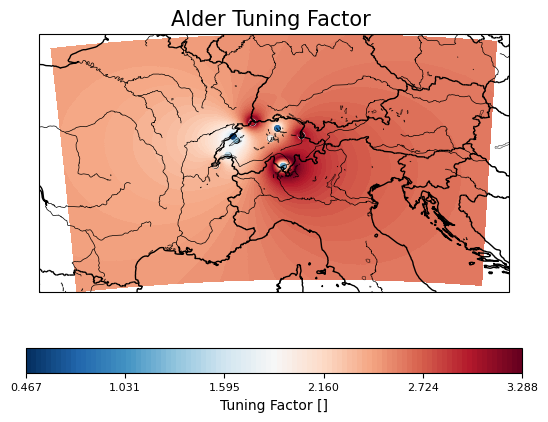

In [43]:
''' 
    Reproduction of subroutine update_strength_realtime
    from the COSMO code.
        Inputs: 
        Outputs:
        Steps: 1) [x] Load data from stations and from the model 
               2) [x] Treat missing data from stations 
               3) [x] Find cell indices of stations from lat-lon info
               4) [x] Modify tune_vec according to stations info
               5) [x] Interpolate over all grid cells
        TODO:  [x] Treat missing data from stations
               [x] INTERPOLATION: Implement IDW as is done in COSMO for different pollen types
               [x] Put everything as functions
               [x] Create python script in src/
               [ ] x Do writing in GRIB file -> commit
               [ ] x Implement the other FORTRAN function and adapt the common functions
               [ ] x check with 1 hr later output
               [x] check if tune_vec is not also used as input in interpolation
                
               
               [ ] Adapt Input management to other cases than ALNU/ICON input
               [ ] test on ICON input with every pollen type
'''

file_data = '/scratch/gvanpary/pollen/data/pollen_measured_values_2022020805.atab'
file_data_mod = '/scratch/gvanpary/pollen/data/pollen_modelled_values_2022022207.atab'

data, data_mod, lat_stns, lon_stns, missing_value, istation_mod = read_atab(file_data, file_data_mod)

pollen_types = ['ALNU', 'BETU', 'POAC', 'CORY']
ipollen = 0
array = data[data['PARAMETER'] == pollen_types[ipollen]].iloc[:,2:].to_numpy()
array_mod = data_mod[data_mod['PARAMETER'] == pollen_types[ipollen]].iloc[:,2:].to_numpy()

'''
    READING DATA FROM GRIB FILE
'''

ds = cfgrib.open_dataset(
        '/scratch/gvanpary/pollen/data/laf2022022207_filtered',
        encode_cf=("time", "geography", "vertical")
    )
array = treat_missing(array, missing_value, verbose = True)
change_tune = update_strength_realtime(array, array_mod, istation_mod, ds)
tune_vec = interpolate(change_tune, ds, 'ALNUtune', lat_stns, lon_stns, 'mult')
plot_tunevec(ds, 'ALNUtune', change_tune, tune_vec, lon_stns, lat_stns)

In [7]:
ds2 = cfgrib.open_dataset(
        '/scratch/gvanpary/pollen/data/laf2022022208_filtered',
        encode_cf=("time", "geography", "vertical")
    )

In [ ]:
ds2['diffr'] = ds2.ALNUtune.copy(deep=True)
ds2.diffr.values = ds2.ALNUtune - ds.tune_vec

ds2['diff_t'] = ds2.ALNUtune.copy(deep=True)
ds2.diff_t.values = ds2.ALNUtune - ds.ALNUtune

ds2['diff_t2'] = ds2.ALNUtune.copy(deep=True)
ds2.diff_t2.values = ds.tune_vec - ds.ALNUtune 

In [ ]:
lonmin = np.amin(ds.longitude)
lonmax = np.amax(ds.longitude)
latmin = np.amin(ds.latitude)
latmax = np.amax(ds.latitude)


plot2= ds2.psy.plot.mapplot(
name="diffr",
title="TUNE(t+1) - Python",
titlesize=15,
map_extent = [lonmin, lonmax, latmin, latmax],
bounds = {'method': 'minmax', 'N':100},
lakes=True,
borders=True,
rivers=True,
cticksize=8,
clabel="Tuning Factor []",
grid_labelsize=8,
projection='robin',
cmap='RdBu_r', xgrid = False, ygrid = False)

plot2= ds2.psy.plot.mapplot(
name="diff_t",
title="TUNE(t+1) - TUNE(t)",
titlesize=15,
map_extent = [lonmin, lonmax, latmin, latmax],
bounds = {'method': 'minmax', 'N':100},
lakes=True,
borders=True,
rivers=True,
cticksize=8,
clabel="Tuning Factor []",
grid_labelsize=8,
projection='robin',
cmap='RdBu_r', xgrid = False, ygrid = False)


plot3= ds2.psy.plot.mapplot(
name="diff_t2",
title="Python - TUNE(t) ",
titlesize=15,
map_extent = [lonmin, lonmax, latmin, latmax],
bounds = {'method': 'minmax', 'N':100},
lakes=True,
borders=True,
rivers=True,
cticksize=8,
clabel="Tuning Factor []",
grid_labelsize=8,
projection='robin',
cmap='RdBu_r', xgrid = False, ygrid = False)

In [ ]:
# auxiliary plotting variables


MIN = np.amin(ds2.ALNUtune)
MAX = np.amax(ds2.ALNUtune)



plot2= ds.psy.plot.mapplot(
name="ALNUtune",
title="ALNU Tuning Factor t",
titlesize=15,
map_extent = [lonmin, lonmax, latmin, latmax],
bounds = {'method': 'minmax', 'N':100, 'vmin': MIN, 'vmax': MAX},
cticks=np.linspace(MIN,MAX,6),
lakes=True,
borders=True,
rivers=True,
cticksize=8,
clabel="Tuning Factor []",
grid_labelsize=8,
projection='robin',
cmap='RdBu_r', xgrid = False, ygrid = False)
fig = plt.gcf()
Nstations = change_tune.shape[0]
pos_lon = np.zeros(Nstations)
pos_lat = np.zeros(Nstations)
tune_stns = np.zeros(Nstations)
tune_stns2 = np.zeros(Nstations)  
eps = 1e-2
for istation in range(Nstations):
    pos_lon[istation],pos_lat[istation] = iconarray.add_coordinates(lon_stns[istation],lat_stns[istation],lonmin,lonmax,latmin,latmax)
    tune_stns[istation] = ds.ALNUtune.where((np.abs(ds.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
    tune_stns2[istation] = ds2.ALNUtune.where((np.abs(ds2.longitude-lon_stns[istation]) < eps)\
                        & (np.abs(ds2.latitude-lat_stns[istation]) < eps), drop=True).values[0][0]
fig.axes[0].scatter(pos_lon, pos_lat,s=50,color='w',marker='o', transform=fig.axes[0].transAxes) 
fig.axes[0].scatter(pos_lon, pos_lat,s=30,color='k',marker='o', transform=fig.axes[0].transAxes) 
fig.axes[0].scatter(pos_lon, pos_lat,s=10,c=tune_stns,marker='o', alpha=1, transform=fig.axes[0].transAxes, vmin=MIN, vmax = MAX, cmap = 'RdBu_r') 



plot1 = ds2.psy.plot.mapplot(
name="ALNUtune",
title="ALNU Tuning Factor t+1",
titlesize=15,
map_extent = [lonmin, lonmax, latmin, latmax],
bounds = {'method': 'minmax', 'N':100, 'vmin': MIN, 'vmax': MAX},
cticks=np.linspace(MIN,MAX,6),
lakes=True,
borders=True,
rivers=True,
cticksize=8,
clabel="Tuning Factor []",
grid_labelsize=8,
projection='robin',
cmap='RdBu_r', xgrid = False, ygrid = False)
fig = plt.gcf()
Nstations = change_tune.shape[0]
pos_lon = np.zeros(Nstations)
pos_lat = np.zeros(Nstations)
for istation in range(Nstations):
    pos_lon[istation],pos_lat[istation] = iconarray.add_coordinates(lon_stns[istation],lat_stns[istation],lonmin,lonmax,latmin,latmax)

fig.axes[0].scatter(pos_lon, pos_lat,s=50,color='w',marker='o', transform=fig.axes[0].transAxes) 
fig.axes[0].scatter(pos_lon, pos_lat,s=30,color='k',marker='o', transform=fig.axes[0].transAxes) 
fig.axes[0].scatter(pos_lon, pos_lat,s=10,c=tune_stns2,marker='o', alpha=1, transform=fig.axes[0].transAxes, vmin=MIN, vmax = MAX, cmap = 'RdBu_r') 


In [ ]:
tune_stns2

In [8]:
ds = cfgrib.open_dataset(
        '/scratch/gvanpary/pollen/data/laf2022020805_filtered',
        encode_cf=("time", "geography", "vertical")
    )
ds

<xarray.Dataset>
Dimensions:            (y: 786, x: 1170)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    surface            float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
    heightAboveGround  float64 ...
Dimensions without coordinates: y, x
Data variables:
    ALNUtthrs          (y, x) float32 ...
    ALNUtthre          (y, x) float32 ...
    ALNUctsum          (y, x) float32 ...
    ALNUsaisn          (y, x) float32 ...
    T_2M               (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich
    history:                 2022-12-14T10:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
ds['ALNU' + 'tthrs']

In [13]:
def get_field_at(ds, field, lon, lat, eps = 1e-2):
    return ds[field].where((np.abs(ds.longitude-lon) < eps)\
                    & (np.abs(ds.latitude-lat) < eps), drop=True).values[0][0]

Current station n°0, last 24H obs 8921.0, and last 120H 64849.0
Cumulative temperature sum 14692.0 and threshold: 1800.0
Current station n°1, last 24H obs 651.0, and last 120H 1619.0
Cumulative temperature sum 6026.0 and threshold: 1855.0
Current station n°2, last 24H obs 673.0, and last 120H 7024.0
Cumulative temperature sum 3613.0 and threshold: 2330.0
Current station n°3, last 24H obs 270.0, and last 120H 1774.0
Cumulative temperature sum 4172.5 and threshold: 1818.0
Current station n°4, last 24H obs 910.0, and last 120H 4911.0
Cumulative temperature sum 4365.5 and threshold: 1871.0
Current station n°5, last 24H obs 258.0, and last 120H 1940.0
Cumulative temperature sum 4068.0 and threshold: 1578.0
Current station n°6, last 24H obs 602.0, and last 120H 3480.0
Cumulative temperature sum 3765.5 and threshold: 1314.0
Current station n°7, last 24H obs 315.0, and last 120H 3034.0
Cumulative temperature sum 5247.5 and threshold: 1686.0
Current station n°8, last 24H obs 153.0, and last 120

/scratch/gvanpary/miniconda3/envs/psyplot/lib/python3.9/site-packages/psy_simple/plugin.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


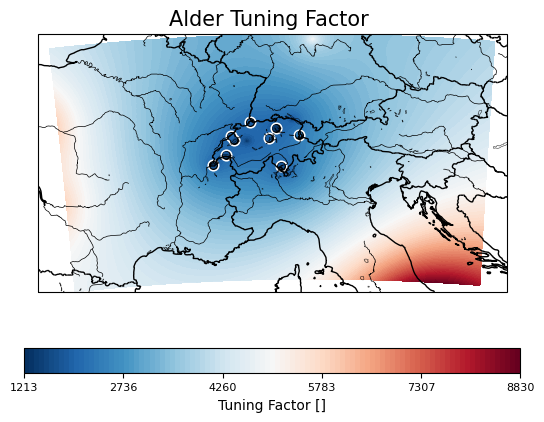

/scratch/gvanpary/miniconda3/envs/psyplot/lib/python3.9/site-packages/psy_simple/plugin.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


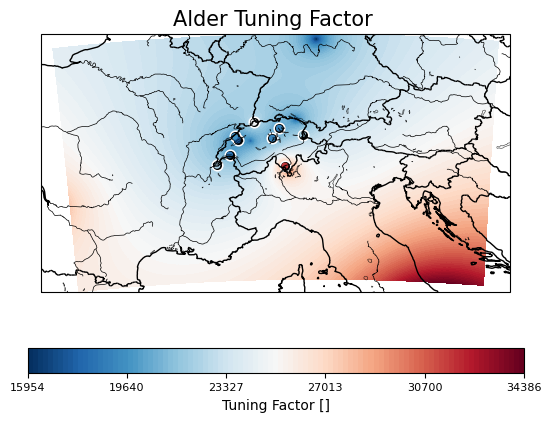

In [47]:
ds = cfgrib.open_dataset(
        '/scratch/gvanpary/pollen/data/laf2022020805_filtered',
        encode_cf=("time", "geography", "vertical")
    )

DATE = pd.Timestamp(ds.time.values).day_of_year + 1 + 31
jul_days_excl = {"ALNUctsum": 14, "BETUctsum": 40, "CORYctsum": 3, "POACctsum": 46}
jul_days_excl = [14,40,3,46]
eps = 1e-2
Nstations = array.shape[1]
change_tthrs = np.zeros(Nstations)
change_tthre = np.zeros(Nstations)
verbose = True
for istation in range(Nstations):
    tthrs_stns = get_field_at(ds, pollen_types[ipollen] + 'tthrs', lon_stns[istation], lat_stns[istation], eps)
    tthre_stns = get_field_at(ds, pollen_types[ipollen] + 'tthre', lon_stns[istation], lat_stns[istation], eps)
    saisn_stns = get_field_at(ds, pollen_types[ipollen] + 'saisn', lon_stns[istation], lat_stns[istation], eps)
    ctsum_stns = get_field_at(ds, pollen_types[ipollen] + 'ctsum', lon_stns[istation], lat_stns[istation], eps)
    T_2M_stns = get_field_at(ds, 'T_2M', lon_stns[istation], lat_stns[istation], eps) - 273.15
    sum_obs_24 = np.sum(array[96:,istation])
    sum_obs = np.sum(array[:,istation])
    print(f'Current station n°{istation}, last 24H obs {sum_obs_24}, and last 120H {sum_obs}')
    print(f'Cumulative temperature sum {ctsum_stns} and threshold: {tthrs_stns}')
    # ADJUSTMENT OF SEASON START AND END AT THE BEGINNING OF THE SEASON
    if ((sum_obs_24 >= 240) and (sum_obs >= 720) and ctsum_stns < tthrs_stns):
        change_tthrs[istation] = (ctsum_stns - tthrs_stns)
        change_tthre[istation] = (ctsum_stns - tthrs_stns)
        if verbose:
            print(f'Big data and below threshold')
    elif ((sum_obs_24 < 240) and (sum_obs_24 >= 0) \
        and (sum_obs < 720) and (sum_obs >= 0)\
        and (ctsum_stns > tthrs_stns) and (ctsum_stns > tthre_stns)\
        and (saisn_stns < 10) and (saisn_stns > 0)):
        if verbose:
            print(f'Low data and in first 10 days of season')
        change_tthrs[istation] = T_2M_stns*(DATE - jul_days_excl[0])
        change_tthre[istation] = T_2M_stns*(DATE - jul_days_excl[0])
        
    # ADJUSTMENT OF SEASON END AT THE END OF THE SEASON
    if ((np.sum(array[96:,istation]) < 240) and (np.sum(array[96:,istation]) >= 0)\
        and (np.sum(array[:,istation]) < 720) and (np.sum(array[:,istation]) >= 0)\
        and (ctsum_stns + T_2M_stns*5*DATE > tthre_stns)\
        and (ctsum_stns < tthre_stns)):
        change_tthre[istation] += (ctsum_stns - tthre_stns)
        if verbose:
            print(f'Big data and below threshold')
    elif ((np.sum(array[96:,istation]) > 240) and (np.sum(array[:,istation]) > 720)\
        and (ctsum_stns + T_2M_stns*5*DATE > tthre_stns)\
        and (ctsum_stns < tthre_stns)):
        change_tthre[istation] += T_2M_stns*(DATE - jul_days_excl[0])
    # FAILSAFE 
    if (change_tthrs[istation] > 0):
        change_tthrs[istation] = min(1000, change_tthrs[istation])
    elif (change_tthrs[istation] <= 0):
        change_tthrs[istation] = max(-1000, change_tthrs[istation])

tthrs_vec = interpolate(change_tthrs, ds, 'ALNUtthrs', lat_stns, lon_stns, 'sum')
tthre_vec = interpolate(change_tthre, ds, 'ALNUtthre', lat_stns, lon_stns, 'sum')
plot_tunevec(ds, 'ALNUtthrs', change_tthrs, tthrs_vec, lon_stns, lat_stns)
plot_tunevec(ds, 'ALNUtthre', change_tthre, tthre_vec, lon_stns, lat_stns)



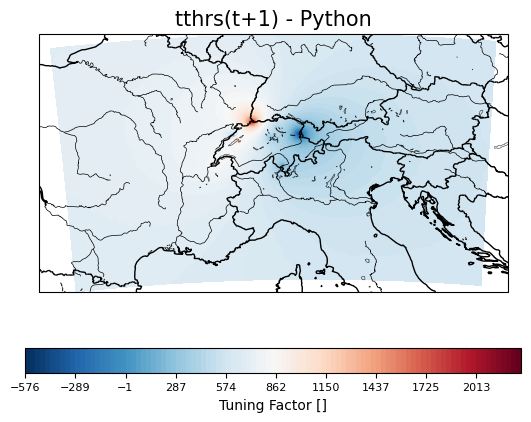

In [57]:
ds2 = cfgrib.open_dataset(
        '/scratch/gvanpary/pollen/data/laf2022020806_filtered',
        encode_cf=("time", "geography", "vertical")
    )

ds2['diffr'] = ds2.ALNUtthrs.copy(deep=True)
ds2.diffr.values = ds2.ALNUtthre -tthre_vec

lonmin = np.amin(ds.longitude)
lonmax = np.amax(ds.longitude)
latmin = np.amin(ds.latitude)
latmax = np.amax(ds.latitude)


plot2= ds2.psy.plot.mapplot(
name="diffr",
title="tthrs(t+1) - Python",
titlesize=15,
map_extent = [lonmin, lonmax, latmin, latmax],
bounds = {'method': 'minmax', 'N':100},
lakes=True,
borders=True,
rivers=True,
cticksize=8,
clabel="Tuning Factor []",
grid_labelsize=8,
projection='robin',
cmap='RdBu_r', xgrid = False, ygrid = False)

In [ ]:
### LEGACY INTERPOLATION METHODS:

'''
import scipy.interpolate as interp  # type: ignore
stns_points = np.array([[lat_stns[i], lon_stns[i]] for i in range(nstns)])
grid_points = np.array(
    [ds.latitude.values.flatten(), ds.longitude.values.flatten()]
).T
if method == "griddata":
    tune_vec = interp.griddata(
        stns_points, change_tune, (ds.latitude.values, ds.longitude.values)
    )
elif method == "RBF":
    tune_vec = interp.RBFInterpolator(
        stns_points, change_tune, kernel="thin_plate_spline"
    )(grid_points).reshape(ds.latitude.values.shape)
elif method == "IDW":
    tune_vec = simple_idw(
        lat_stns,
        lon_stns,
        change_tune,
        ds.latitude.values.flatten(),
        ds.longitude.values.flatten(),
    ).reshape(ds.latitude.values.shape)
elif method == "Bspline":
    Bspline = interp.interp2d(lat_stns, lon_stns, change_tune, kind="linear")
    tune_vec = np.array(
        [
            Bspline(i, j)
            for i, j in zip(
                ds.latitude.values.flatten(), ds.longitude.values.flatten()
            )
        ]
    ).reshape(ds.latitude.values.shape)'''

In [58]:
10 < 20 < 30

True